## Задание 1

[kaggle task](https://www.kaggle.com/vjchoudhary7/customer-segmentation-tutorial-in-python)

Есть датасет с характеристиками покупателей в магазине.
<br>
Требуется разбить покупателей на k кластеров (выбор k остается за тобой), посчитать силуэт и визуализировать полученные кластеры

Выбор k должен быть обоснован, применять можно абсолютно любые алгоритмы.

**Заметка**: можно генерировать новые признаки и/или не использовать все имеющиеся, да и вообще делать все, что угодно и не противоречит здравому смыслу :)

**Не забывай фиксировать random_state для воспроизводимости результатов, где это требуется**

In [ ]:
pip install MulticoreTSNE

In [ ]:
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN

from MulticoreTSNE import MulticoreTSNE as TSNE
from sklearn.decomposition import PCA

from sklearn.metrics import silhouette_score

from pathlib import Path

from sklearn.metrics import accuracy_score

##other libraries on need##

In [ ]:
SEED = 42

In [ ]:
X = pd.read_csv(Path('mall_customers.csv'))
print(X.shape)
X.head()

(200, 5)


,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [ ]:
X = X.replace(to_replace=['Male', 'Female'], value=[1, 0])
X.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,1,19,15,39
1,2,1,21,15,81
2,3,0,20,16,6
3,4,0,23,16,77
4,5,0,31,17,40


PCA

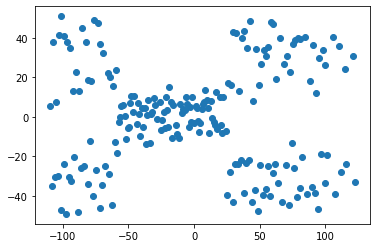

In [ ]:
pca = PCA(n_components=2, random_state=SEED).fit(X)
X_pca = pca.transform(X)
plt.scatter(X_pca[:,0], X_pca[:,1])

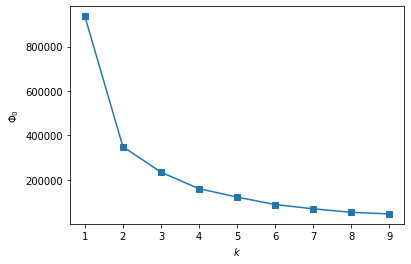

In [ ]:
inertia = []
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=1).fit(X_pca)
    inertia.append(kmeans.inertia_)

plt.plot(range(1, 10), inertia, marker='s');
plt.xlabel('$k$')
plt.ylabel('$\Phi_0$');

K-means

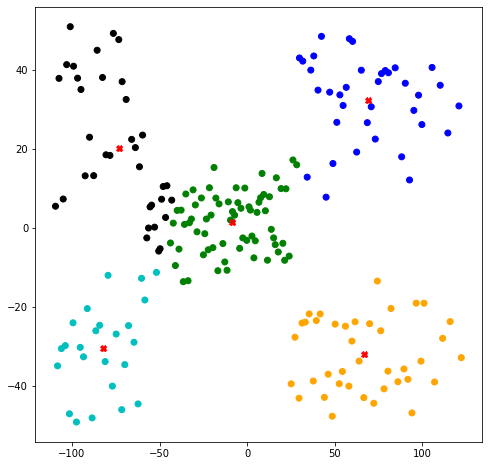

In [ ]:
#fit
kmeans = KMeans(n_clusters=5, n_jobs=-1).fit(X_pca)
#predict
yhat_kmeans = kmeans.predict(X_pca) #=kmeans.labels_

#plot
colors = ['c' if x==0 else 'b' if x==1 else 'g' if x==2 else 'orange' if x==3 else 'black' for x in yhat_kmeans]

plt.figure(figsize=(8,8))
for i in range(kmeans.cluster_centers_.shape[0]):
    plt.plot(kmeans.cluster_centers_[i, 0], kmeans.cluster_centers_[i, 1], 'rX')
plt.scatter(X_pca[:,0], X_pca[:,1], c=colors, picker=True);

In [ ]:
print(f'Silhouette score K-means: {silhouette_score(X_pca, yhat_kmeans)}')

Silhouette score K-means: 0.4835425351538953


t-SNE

In [ ]:
X_reduc = TSNE(n_components=2, random_state=SEED, metric='euclidean', n_jobs=-1).fit_transform(X)

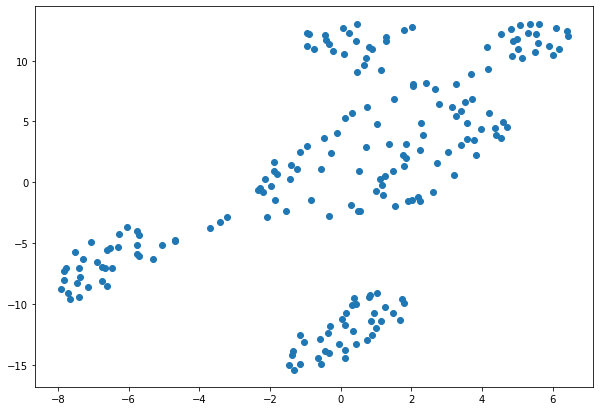

In [ ]:
plt.figure(figsize=(10, 7))
plt.scatter(X_reduc[:, 0], X_reduc[:, 1])

DBSCAN

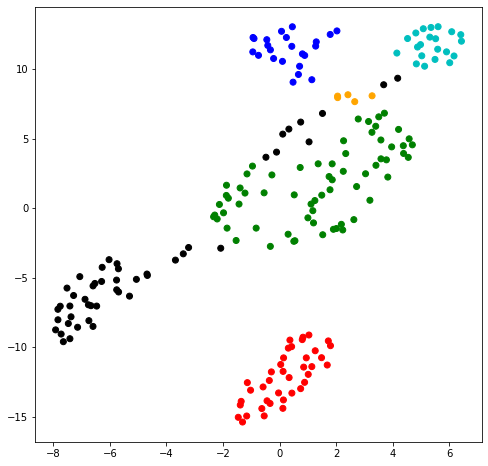

In [ ]:
dbscan = DBSCAN(eps=1.2, min_samples=5, n_jobs=-1).fit(X_reduc)
yhat_dbscan = dbscan.labels_

colors = ['c' if x==0 else 'b' if x==1 else 'g' if x==2 else 'orange' if x==3 else 'r' if x==4 else 'black'  for x in yhat_dbscan]
#plot
plt.figure(figsize=(8,8))
plt.scatter(X_reduc[:,0], X_reduc[:,1], c=colors, picker=True);

In [ ]:
print(f'Silhouette score DBSCAN: {silhouette_score(X_reduc, yhat_dbscan)}')

Silhouette score DBSCAN: 0.44266152925871843


## Задание 2 (по желанию)

Возьмем стандартный датасет ирисов, состоящий из 4-х признаков длины/ширины внутренней и наружной долей околоцветника и таргета - вид цветка (kind).

1.Требуется кластеризовать цветки (да-да, количество кластеров уже известно), посчитать **accuracy**. Выбор алгоритма опять же на усмотрение (может быть несколько)
<br>
**Важно**: метки могут расставиться в другом порядке относительно истинного таргета, то есть после кластеризации будут получены 0, а это на самом деле 1, то есть надо сделать отображение $0 \rightarrow 1$ , то же самое касается и других меток. 
<br>
Поэтому, получив метки кластеров, стоит перебрать все возможные их перестановки. В этом поможет itertools.permutations

2.Воспользоваться любым/любыми пройденными/известными алгоритмами классификации и посчитать **accuracy** 
<br>
(Например, логистической регрессией)

In [ ]:
from sklearn import datasets
import itertools

##other libraries on need##

In [ ]:
df = datasets.load_iris()
df = pd.DataFrame(np.hstack([df['data'], df['target'].reshape(-1,1)])
             , columns=['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'kind'])

print('Count of unique flowers', df['kind'].unique().shape[0])
df.head()

Count of unique flowers 3


,sepal_length,sepal_width,petal_length,petal_width,kind
0,5.1,3.5,1.4,0.2,0.0
1,4.9,3.0,1.4,0.2,0.0
2,4.7,3.2,1.3,0.2,0.0
3,4.6,3.1,1.5,0.2,0.0
4,5.0,3.6,1.4,0.2,0.0


### Кластеризация

In [ ]:
def validate_with_mappings(y_true, y_pred):
    '''
    Check all possible permutations to maximize accuracy
    '''
    
    l = []
    permutations = itertools.permutations([0, 1, 2])
    for a, b, c in permutations:
        mapping = {0 : a, 1: b, 2: c}
        #print(mapping)
        mapped_preds = [mapping[pred] for pred in y_pred]
        #print(mapped_preds)
        l.append((mapping, sum(mapped_preds == y_true) / len(y_true)))
        #print(l)         
    return l

In [ ]:
X = df.iloc[:, :-1]
y = df['kind']

In [ ]:
X.head()

,sepal_length,sepal_width,petal_length,petal_width
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


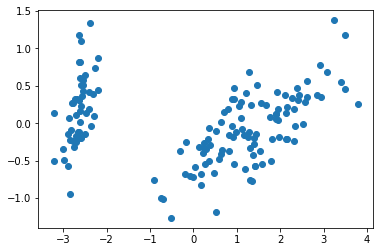

In [ ]:
pca = PCA(n_components=2, random_state=SEED).fit(X)
X_pca = pca.transform(X)
plt.scatter(X_pca[:,0], X_pca[:,1])

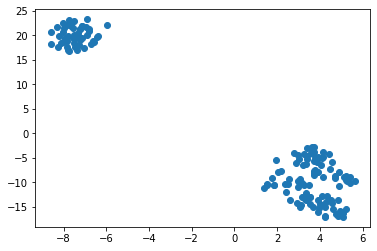

In [ ]:
X_reduc = TSNE(n_components=2, random_state=SEED, metric='euclidean', n_jobs=-1).fit_transform(X)
plt.scatter(X_reduc[:, 0], X_reduc[:, 1])

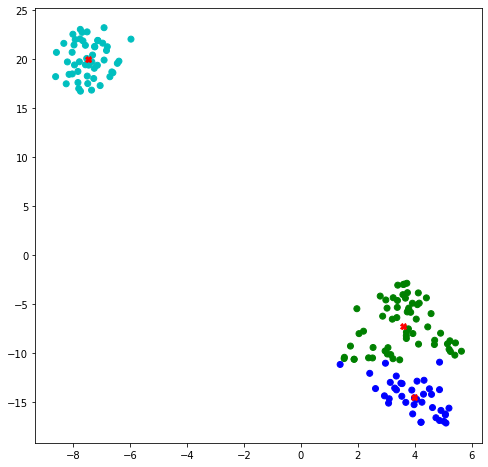

In [ ]:
#fit
kmeans = KMeans(n_clusters=3, n_jobs=-1).fit(X_reduc)
#predict
yhat_kmeans = kmeans.predict(X_reduc) #=kmeans.labels_

#plot
colors = ['c' if x==0 else 'b' if x==1 else 'g'  for x in yhat_kmeans]

plt.figure(figsize=(8,8))
for i in range(kmeans.cluster_centers_.shape[0]):
    plt.plot(kmeans.cluster_centers_[i, 0], kmeans.cluster_centers_[i, 1], 'rX')
plt.scatter(X_reduc[:,0], X_reduc[:,1], c=colors, picker=True);

In [ ]:
print(f'Silhouette score K-means: {silhouette_score(X_reduc, yhat_kmeans)}')

Silhouette score K-means: 0.6793520344740945


In [ ]:
squarer = lambda x: 0 if x == 0 else 2 if x == 1 else 1
yhat_kmeans1 = np.array([squarer(xi) for xi in yhat_kmeans])
yhat_kmeans1

In [ ]:
accuracy_score(y, yhat_kmeans1)

0.9133333333333333

### Классификация

Дерево решений

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier 

In [ ]:
X = df.iloc[:, :-1]
y = df['kind']

In [ ]:
#на чистом датасете
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3,
                                                   # stratify=y
                                                    random_state= SEED)

clf = DecisionTreeClassifier(max_depth=2, random_state= SEED)
clf.fit(X_train, y_train)
preds = clf.predict_proba(X_test)
#preds = clf.predict(X_test)
print('Accuracy: {:.5f}'.format(accuracy_score(y_test, 
                                                preds.argmax(axis=1))))

Accuracy: 0.97778


In [ ]:
X = df.iloc[:, :-1]
y = df['kind']

In [ ]:
#на данных после PCA
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=.3,
                                                   # stratify=y
                                                    random_state= SEED)

clf = DecisionTreeClassifier(max_depth=2, random_state= SEED)
clf.fit(X_train, y_train)
preds = clf.predict_proba(X_test)
#preds = clf.predict(X_test)
print('Accuracy: {:.5f}'.format(accuracy_score(y_test, 
                                                preds.argmax(axis=1))))

Accuracy: 0.95556


Лог регрессия

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
X = df.iloc[:, :-1]
y = df['kind']

In [ ]:
pca = PCA(n_components=1, random_state=SEED).fit(X)
X_pca = pca.transform(X)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=.3,
                                                   # stratify=y
                                                    random_state= SEED)

clf = LogisticRegression(random_state=SEED).fit(X_train, y_train)
#clf.predict(X_test)
pred = clf.predict_proba(X_test)

print('Accuracy: {:.5f}'.format(accuracy_score(y_test, 
                                                pred.argmax(axis=1))))

Accuracy: 0.97778


In [ ]:
pred.argmax(axis=1)

array([1, 0, 2, 1, 2, 0, 1, 2, 1, 1, 2, 0, 0, 0, 0, 1, 2, 1, 1, 2, 0, 2,
       0, 2, 2, 2, 2, 2, 0, 0, 0, 0, 1, 0, 0, 2, 1, 0, 0, 0, 2, 1, 1, 0,
       0])

KNN

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
X = df.iloc[:, :-1]
y = df['kind']

In [ ]:
X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, test_size=0.3,
random_state= SEED)

knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)

In [ ]:
knn_pred = knn.predict(X_holdout)
accuracy_score(y_holdout, knn_pred)

1.0